In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path
from glob import glob
from subprocess import check_call, CalledProcessError

import numpy as np
import yaml

import matplotlib.pyplot as plt

import cson_forge

ERROR 1: PROJ: proj_create_from_database: Open of /global/u2/m/mattlong/.local/share/mamba/envs/cson-forge-v0/share/proj failed



Query the blueprint catalog to find the run blueprint matching the specified model and grid. This provides the path to the simulation output directory.


Find all model output files matching the pattern. These files contain the time-series data for the variable of interest.

In [2]:
domains_file = "domains-bm-scaling.yml"

In [3]:
# Read domains file and extract domain keys
# Resolve domains file path (relative to notebook directory)
domains_path = Path(domains_file)
if not domains_path.is_absolute():
    domains_path = Path.cwd() / domains_path

# Load domains YAML file
with open(domains_path, 'r') as f:
    domains_data = yaml.safe_load(f) or {}

# Extract domain keys (main keys in the YAML file)
domain_keys = list(domains_data.keys())

print(f"Loaded {len(domain_keys)} domain(s) from {domains_path}")
print(f"Domain keys: {domain_keys}")

Loaded 5 domain(s) from /global/u2/m/mattlong/codes/cson-forge/workflows/computing-benchmarks/domains-bm-scaling.yml
Domain keys: ['ccs-12km_20procs', 'ccs-12km_70procs', 'ccs-12km_280procs', 'ccs-12km_352procs', 'ccs-12km_1120procs']



Load the model grid from the blueprint's grid YAML file. The grid provides coordinate information (lon_rho, lat_rho) and masking for proper visualization.

In [5]:
df = cson_forge.catalog.blueprint.load(stage="run")
# Blueprint names are {model_name}_{grid_name}_{n_procs}procs
# Domain keys are {grid_name}_{n_procs}procs
# So we need to check if blueprint_name ends with any domain_key
df = df.loc[df.blueprint_name.str.endswith(tuple(domain_keys))]

if df.empty:
    raise ValueError(
        f"No blueprints found: blueprint_name='{domain_keys}' "
        f"at stage='run'"
    )

df

,model_name,grid_name,blueprint_name,description,start_time,end_time,blueprint_path,grid_yaml_path,stage
0,cson_roms-marbl_v0.1_ccs-12km,20procs,cson_roms-marbl_v0.1_ccs-12km_20procs,California Current System,2024-01-01T00:00:00,2024-01-02T00:00:00,/global/u2/m/mattlong/codes/cson-forge/cson_fo...,/global/u2/m/mattlong/codes/cson-forge/cson_fo...,run
1,cson_roms-marbl_v0.1_ccs-12km,280procs,cson_roms-marbl_v0.1_ccs-12km_280procs,California Current System,2024-01-01T00:00:00,2024-01-02T00:00:00,/global/u2/m/mattlong/codes/cson-forge/cson_fo...,/global/u2/m/mattlong/codes/cson-forge/cson_fo...,run
2,cson_roms-marbl_v0.1_ccs-12km,352procs,cson_roms-marbl_v0.1_ccs-12km_352procs,California Current System,2024-01-01T00:00:00,2024-01-02T00:00:00,/global/u2/m/mattlong/codes/cson-forge/cson_fo...,/global/u2/m/mattlong/codes/cson-forge/cson_fo...,run
3,cson_roms-marbl_v0.1_ccs-12km,70procs,cson_roms-marbl_v0.1_ccs-12km_70procs,California Current System,2024-01-01T00:00:00,2024-01-02T00:00:00,/global/u2/m/mattlong/codes/cson-forge/cson_fo...,/global/u2/m/mattlong/codes/cson-forge/cson_fo...,run


In [15]:
job_ids = {}
for i in range(len(df)):
    key = df.blueprint_name.iloc[i]
    blueprint_path = df.blueprint_path.iloc[i]
    casename = blueprint_path.stem.replace("B_", "").replace("_run", "") # get less janky
    simulation_dir = Path(cson_forge.config.paths.scratch / casename)
    log_file = simulation_dir / "logs" / (f"{casename}".replace("_run", "").replace(".", "-") + ".out")
    if not log_file.exists():
        print(f"Log file {log_file} does not exist")
        continue
    
    job_ids[key] = cson_forge.parsers.parse_slurm_job_id(log_file)

job_ids

{'cson_roms-marbl_v0.1_ccs-12km_20procs': '48052911',
 'cson_roms-marbl_v0.1_ccs-12km_280procs': '48052912',
 'cson_roms-marbl_v0.1_ccs-12km_352procs': '48052913',
 'cson_roms-marbl_v0.1_ccs-12km_70procs': '48052914'}

In [22]:
job_info = {}

ntasks = []
time = []
print(f"model:\tntasks\ttime")
for key, job_id in job_ids.items():
    job_info[key] = cson_forge.parsers.sacct_summary(job_id)
    n = job_info[key]["ntasks"]
    t = job_info[key]["elapsed_time"]
    print(f"{key}:\t{n}\t{t}")
    ntasks.append(n)
    time.append(t)    

model:	ntasks	time
cson_roms-marbl_v0.1_ccs-12km_20procs:	20	5347
cson_roms-marbl_v0.1_ccs-12km_280procs:	280	1019
cson_roms-marbl_v0.1_ccs-12km_352procs:	352	915
cson_roms-marbl_v0.1_ccs-12km_70procs:	70	1930


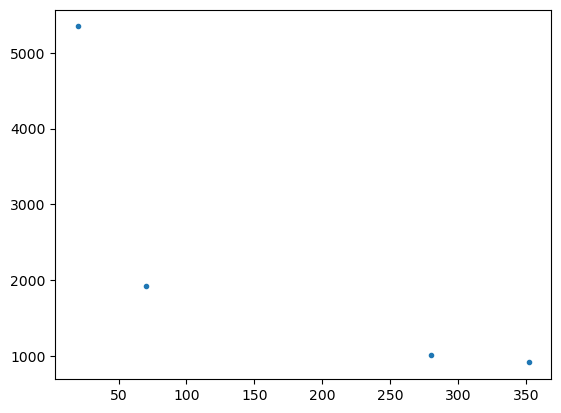

In [23]:
plt.plot(ntasks, time, '.')